<a href="https://colab.research.google.com/github/bosco-morales/Deep-Learning-Practice/blob/main/class_05292024_nn_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class of Wednesday, May 29 2024

In [2]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read File
df = pd.read_csv('https://raw.githubusercontent.com/bosco-morales/Deep-Learning-Practice/main/Class_05292024/house_price_prediction.csv')

In [4]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


## Data Wrangling 1

In [5]:
# Drop unneessary columns
to_drop = ['date', 'street', 'statezip', 'country']
df.drop(to_drop, axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond


## Feature Engineering

In [6]:
# Create a new column for the house age
df['house_age'] = [2024 - yr_built for yr_built in df['yr_built']]

In [7]:
# Create a new column for how recent a renovation took place
df['was_renovated'] = [1 if yr_renovated != 0 else 0
                       for yr_renovated in df['yr_renovated']]
df['was_renovated_10_yrs'] = [1 if (2024 - yr_renovated) <= 10
                              else 0 for yr_renovated in df['yr_renovated']]
df['was reonvated_30_yrs'] = [1 if 10 < (2024 - yr_renovated) <= 30
                              else 0 for yr_renovated in df['yr_renovated']]


In [8]:
# Drop original columns
df.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

In [9]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,city,house_age,was_renovated,was_renovated_10_yrs,was reonvated_30_yrs
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,Shoreline,69,1,0,1
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,Seattle,103,0,0,0
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,Kent,58,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,Bellevue,61,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,Redmond,48,1,0,0


In [10]:
# Count of occurrences of each city
city_counts = df['city'].value_counts()

print("Count of occurrences for each city:")
print(city_counts)

Count of occurrences for each city:
city
Seattle                1573
Renton                  293
Bellevue                286
Redmond                 235
Kirkland                187
Issaquah                187
Kent                    185
Auburn                  176
Sammamish               175
Federal Way             148
Shoreline               123
Woodinville             115
Maple Valley             96
Mercer Island            86
Burien                   74
Snoqualmie               71
Kenmore                  66
Des Moines               58
North Bend               50
Covington                43
Duvall                   42
Lake Forest Park         36
Bothell                  33
Newcastle                33
Tukwila                  29
SeaTac                   29
Vashon                   29
Enumclaw                 28
Carnation                22
Normandy Park            18
Clyde Hill               11
Fall City                11
Medina                   11
Black Diamond             9
Ravensd

Dr. Lee made an arbitrary decision label all cities with counts < 50 to 'Rare'

In [11]:
def remap_location(data: pd.DataFrame,
                   location: str,
                   treshold: int = 50) -> str:
    if len(data[data["city"] == location]) < treshold:
        return "Rare"
    else:
        return location

In [12]:
df['city'] = df['city'].apply(
    lambda x: remap_location(data=df, location=x)
)

## Data Wranling 2

Normalize target variable 'Price' by applying the Z-test

(array([  1.,   0.,   0.,   8.,  12.,  21.,  37.,  55.,  81., 133., 189.,
        182., 152., 222., 184., 174., 189., 176., 176., 201., 166., 141.,
        146., 163., 158., 115., 131.,  96.,  91., 107.,  71.,  64.,  81.,
         75.,  50.,  66.,  41.,  55.,  44.,  39.,  22.,  24.,  33.,  28.,
         17.,  16.,  22.,  12.,  16.,   7.,  12.,  13.,   9.,  14.,  14.,
         12.,   5.,  15.,   5.,  11.,   7.,   7.,  11.,   3.,   2.,   2.,
          3.,   3.,   3.,   5.,   5.,   6.,   4.,   2.,   4.,   7.,   2.,
          5.,   2.,   0.,   5.,   2.,   0.,   2.,   4.,   2.,   0.,   3.,
          1.,   3.,   1.,   0.,   2.,   1.,   2.,   1.,   1.,   1.,   2.,
          1.]),
 array([   7800.  ,   30110.88,   52421.76,   74732.64,   97043.52,
         119354.4 ,  141665.28,  163976.16,  186287.04,  208597.92,
         230908.8 ,  253219.68,  275530.56,  297841.44,  320152.32,
         342463.2 ,  364774.08,  387084.96,  409395.84,  431706.72,
         454017.6 ,  476328.48,  498639.36,  5

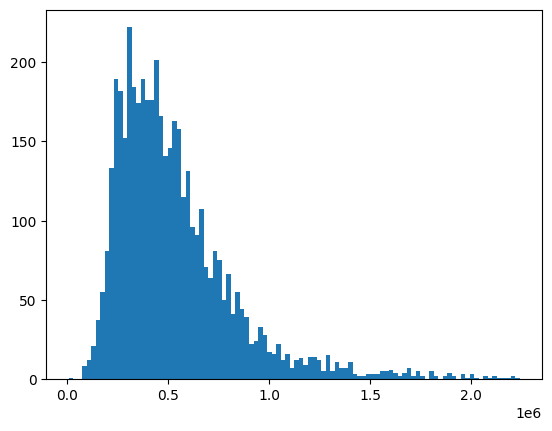

In [13]:
from scipy import stats

# Calculate Z-values
df['price_z'] = np.abs(stats.zscore(df['price']))

# Filter out outliers
df = df[df['price_z'] < 3]

# Remove houses listed for $0
df = df[df['price'] != 0]

# Drop the column
df.drop('price_z', axis=1, inplace=True)

# Draw histogram
plt.hist(df['price'], bins=100)


Scale and Encode

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [15]:
transformer = make_column_transformer(
    (MinMaxScaler(),
     ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'house_age']),
    (OneHotEncoder(handle_unknown='ignore'),
      ['bedrooms', 'bathrooms', 'floors', 'view', 'condition'])
)

## Data Split


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
transformer.fit(X_train)

# Apply the transformation
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [19]:
X_train = X_train.toarray()
X_test = X_test.toarray()

## Train a Regression Model with TensorFlow

In [20]:
# Standard Imports for Training
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


In [21]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [22]:
tf.random.set_seed(42)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(
    loss = rmse,
    optimizer = Adam(),
    metrics = [rmse]
)

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
113/113 [==============================] - 1s 3ms/step - loss: 606477.2500 - rmse: 606493.2500
Epoch 2/100
113/113 [==============================] - 0s 3ms/step - loss: 414933.7500 - rmse: 414761.2188
Epoch 3/100
113/113 [==============================] - 0s 3ms/step - loss: 266411.5938 - rmse: 266387.3125
Epoch 4/100
113/113 [==============================] - 0s 2ms/step - loss: 247345.7188 - rmse: 247288.2188
Epoch 5/100
113/113 [==============================] - 0s 3ms/step - loss: 237740.0781 - rmse: 237806.8125
Epoch 6/100
113/113 [==============================] - 0s 3ms/step - loss: 229732.0469 - rmse: 229683.2812
Epoch 7/100
113/113 [==============================] - 0s 3ms/step - loss: 226201.7969 - rmse: 226170.2969
Epoch 8/100
113/113 [==============================] - 0s 3ms/step - loss: 221878.7500 - rmse: 221908.7188
Epoch 9/100
113/113 [==============================] - 0s 3ms/step - loss: 218063.5781 - rmse: 218006.6719
Epoch 10/100
113/113 [===============

In [23]:
predictions = model.predict(X_test)
predictions[:5]

29/29 [==============================] - 0s 1ms/step


array([[ 496164.5 ],
       [ 599539.44],
       [1230369.9 ],
       [ 277930.03],
       [ 319663.53]], dtype=float32)

Convert previous output into a one dimensional array

In [24]:
predictions = np.ravel(predictions)
predictions[:5]

array([ 496164.5 ,  599539.44, 1230369.9 ,  277930.03,  319663.53],
      dtype=float32)

In [25]:
rmse(y_test, predictions).numpy()

191134.20776031679